In [25]:
import numpy as np
import pandas as pd
import scipy as sc

import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

In [73]:
#Task 1. Загрузка файла
test=pd.read_csv("C:/Users/gordee-ext/OneDrive - Louis Dreyfus Company/Desktop/Netology/Задание 2/rosbank_test.csv")
train=pd.read_csv("C:/Users/gordee-ext/OneDrive - Louis Dreyfus Company/Desktop/Netology/Задание 2/rosbank_train.csv")

In [27]:
test.head(3)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category
0,01/04/2017,2,5814,NaN,810,18APR17:00:00:00,153.00,POS
1,01/03/2017,2,5812,NaN,810,10MAR17:00:00:00,388.08,POS
2,01/02/2017,2,5691,NaN,810,21FEB17:00:00:00,999.00,POS


In [28]:
train.head(3)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0


In [29]:
test.shape

(518376, 8)

In [30]:
train.shape

(490513, 10)

In [74]:
def get_aggregated_df(df, agg_type, col_to_groupby):
    agg_df=df[['cl_id',col_to_groupby, 'amount']].groupby(['cl_id',col_to_groupby]).agg([agg_type])
    agg_df=agg_df.unstack(fill_value=0)
    agg_df.columns=agg_df.columns.get_level_values(2)
    old_name=agg_df.columns.name
    old_cols=agg_df.columns
    new_cols=[old_name+'_'+agg_type+'_'+str(old_col) for old_col in old_cols]
    agg_df.rename(columns={old_col:new_col for old_col, new_col in zip(old_cols,new_cols)}, inplace=True)
    return agg_df

In [32]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518376 entries, 0 to 518375
Data columns (total 8 columns):
PERIOD          518376 non-null object
cl_id           518376 non-null int64
MCC             518376 non-null int64
channel_type    516222 non-null object
currency        518376 non-null int64
TRDATETIME      518376 non-null object
amount          518376 non-null float64
trx_category    518376 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 31.6+ MB


In [75]:
#Task 3. Агрегация данных и создание новых фич
#общая сумма транзакций по каждой из trx_category TEST

trx_cat_count_test=get_aggregated_df(test,'count','trx_category')
trx_cat_count_test.sum().sort_values(ascending = False).head(3)

trx_category
trx_category_count_POS           442149
trx_category_count_DEPOSIT        21870
trx_category_count_WD_ATM_ROS     19310
dtype: int64

In [76]:
#общая сумма транзакции по основным вылютам RUB-810, USD-840, EUR-978 TEST
currency_count_test=get_aggregated_df(test,'count','currency')
currency_count_test.sum().sort_values(ascending = False).head(3)

currency
currency_count_810    504087
currency_count_978      6037
currency_count_840      1887
dtype: int64

In [77]:
#общая сумма транзакций по категориям MCC кодов (например, выбрать основные/популярные MCC коды). TEST
mcc_count_test=get_aggregated_df(test,'count','MCC')
mcc_count_test.sum().sort_values(ascending = False).head(3)

MCC
MCC_count_5411    129455
MCC_count_6011     55341
MCC_count_5814     43407
dtype: int64

In [78]:
#общая сумма транзакций по каждой из trx_category TRAIN
trx_cat_count_train=get_aggregated_df(train,'count','trx_category')
trx_cat_count_train.sum().sort_values(ascending = False).head(3)
#наиболее популярны POS и DEPOSIT

trx_category
trx_category_count_POS           416425
trx_category_count_DEPOSIT        21216
trx_category_count_WD_ATM_ROS     19104
dtype: int64

In [79]:
#общая сумма транзакции по основным вылютам RUB-810, USD-840, EUR-978  TRAIN
currency_count_train=get_aggregated_df(train,'count','currency')
currency_count_train.sum().sort_values(ascending = False).head(3)

currency
currency_count_810    477644
currency_count_978      5536
currency_count_840      1921
dtype: int64

In [80]:
#общая сумма транзакций по категориям MCC кодов (например, выбрать основные/популярные MCC коды). TRAIN
mcc_count_train=get_aggregated_df(train,'count','MCC')
mcc_count_train.sum().sort_values(ascending = False).head(3)
#наиболее популярные МСС 5411, 6011, 5814

MCC
MCC_count_5411    121640
MCC_count_6011     54382
MCC_count_5814     41351
dtype: int64

In [81]:
print(test.describe())
test.mode().head(1)

               cl_id            MCC       currency        amount
count  518376.000000  518376.000000  518376.000000  5.183760e+05
mean     4783.074162    5691.949272     810.661423  5.510122e+03
std      2928.769547     663.012413      39.138519  4.480448e+04
min         2.000000     742.000000      32.000000  1.000000e-02
25%      2181.000000    5411.000000     810.000000  2.180000e+02
50%      4591.000000    5655.000000     810.000000  6.090000e+02
75%      7304.000000    5921.000000     810.000000  2.113000e+03
max     10216.000000    9405.000000     986.000000  1.825285e+07


,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category
0,01/07/2017,1614,5411,type1,810,30DEC16:00:00:00,1000.0,POS


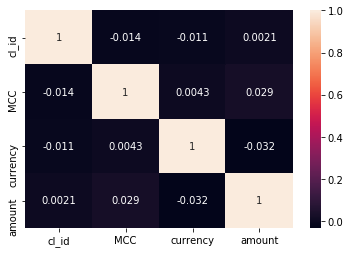

In [40]:
corr=test.corr()
sns.heatmap(corr,annot=True, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017981D9B240>,
      dtype=object)

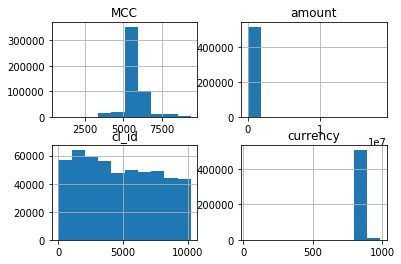

In [41]:
test.hist()

In [82]:
train.groupby(['PERIOD','trx_category']).count()

cl_id    MCC  channel_type  currency  TRDATETIME  \
PERIOD     trx_category                                                       
01/01/2017 BACK_TRX          302    302           301       302         302   
           C2C_IN            696    696           694       696         696   
           C2C_OUT           382    382           382       382         382   
           CASH_ADV            1      1             1         1           1   
           CAT                84     84            84        84          84   
           DEPOSIT          2279   2279          2270      2279        2279   
           POS             38085  38085         37968     38085       38085   
           WD_ATM_OTHER      407    407           406       407         407   
           WD_ATM_PARTNER    691    691           691       691         691   
           WD_ATM_ROS       1327   1327          1327      1327        1327   
01/01/2018 BACK_TRX           17     17            17        17          17   
           C2C_IN             55     55            55        55          55   
           C2C_OUT           109    109           109       109         109   
           CAT                 9      9             9         9           9   
           DEPOSIT            87     87            87        87          87   
           POS              2810   2810          2735      2810        2810   
           WD_ATM_OTHER       83     83            82        83          83   
           WD_ATM_PARTNER     49     49            49        49          49   
           WD_ATM_ROS        178    178           177       178         178   
01/02/2017 BACK_TRX          238    238           237       238         238   
           C2C_IN            497    497           493       497         497   
           C2C_OUT           353    353           353       353         353   
           CASH_ADV            2      2             2         2           2   
           CAT                92     92            92        92          92   
           DEPOSIT          1889   1889          1883      1889        1889   
           POS             31982  31982         31824     31982       31982   
           WD_ATM_OTHER      370    370           370       370         370   
           WD_ATM_PARTNER    727    727           725       727         727   
           WD_ATM_ROS       1159   1159          1155      1159        1159   
01/02/2018 BACK_TRX            8      8             8         8           8   
...                          ...    ...           ...       ...         ...   
01/11/2016 WD_ATM_ROS        775    775           775       775         775   
01/11/2017 BACK_TRX           32     32            32        32          32   
           C2C_IN             86     86            83        86          86   
           C2C_OUT           171    171           168       171         171   
           CASH_ADV            1      1             1         1           1   
           CAT                 8      8             8         8           8   
           DEPOSIT           172    172           172       172         172   
           POS              4286   4286          4209      4286        4286   
           WD_ATM_OTHER      111    111           103       111         111   
           WD_ATM_PARTNER    130    130           129       130         130   
           WD_ATM_ROS        371    371           362       371         371   
01/12/2016 BACK_TRX          274    274           274       274         274   
           C2C_IN            706    706           704       706         706   
           C2C_OUT           373    373           373       373         373   
           CASH_ADV            2      2             2         2           2   
           CAT               112    112           112       112         112   
           DEPOSIT          2913   2913          2910      2913        2913   
           POS             38455  38455         38380     38455       38455  

In [83]:
train['TRDATETIME'].apply(
        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')))

0        2017-10-21 00:00:00
1        2017-10-12 12:24:07
2        2017-12-05 00:00:00
3        2017-10-21 00:00:00
4        2017-10-24 13:14:24
5        2017-10-16 00:00:00
6        2017-10-10 00:00:00
7        2017-10-16 00:00:00
8        2017-10-11 00:00:00
9        2017-07-26 00:00:00
10       2017-09-30 00:00:00
11       2017-08-02 00:00:00
12       2017-10-01 00:00:00
13       2017-07-31 00:00:00
14       2017-10-08 00:00:00
15       2017-10-14 00:00:00
16       2017-09-16 00:00:00
17       2017-09-21 00:00:00
18       2017-07-24 00:00:00
19       2017-09-26 00:00:00
20       2017-09-19 00:00:00
21       2017-09-27 00:00:00
22       2017-09-20 00:00:00
23       2017-09-27 00:00:00
24       2017-08-15 00:00:00
25       2017-10-03 00:00:00
26       2017-09-28 00:00:00
27       2017-10-02 00:00:00
28       2017-09-06 00:00:00
29       2017-10-02 00:00:00
                 ...        
490483   2016-11-23 09:01:53
490484   2017-01-06 00:00:00
490485   2017-07-19 11:29:38
490486   2017-

In [84]:
test['TRDATETIME'].apply(
        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')))

0        2017-04-18 00:00:00
1        2017-03-10 00:00:00
2        2017-02-21 00:00:00
3        2017-04-26 00:00:00
4        2017-04-08 00:00:00
5        2017-03-24 00:00:00
6        2017-04-24 00:00:00
7        2017-03-28 00:00:00
8        2017-04-08 00:00:00
9        2017-04-27 00:00:00
10       2017-02-27 00:00:00
11       2017-03-31 00:00:00
12       2017-03-06 00:00:00
13       2017-04-12 00:00:00
14       2017-04-14 00:00:00
15       2017-03-17 00:00:00
16       2017-04-18 00:00:00
17       2017-03-31 00:00:00
18       2017-04-10 00:00:00
19       2017-02-09 00:00:00
20       2017-03-01 00:00:00
21       2017-02-21 13:08:28
22       2017-03-16 00:00:00
23       2017-04-27 00:00:00
24       2017-04-20 00:00:00
25       2017-02-03 00:00:00
26       2017-02-20 00:00:00
27       2017-04-07 00:00:00
28       2017-02-28 09:20:36
29       2017-04-26 00:00:00
                 ...        
518346   2017-02-20 00:00:00
518347   2017-02-20 00:00:00
518348   2017-02-20 00:00:00
518349   2017-

In [85]:
#Task 4
targets = train[['cl_id', 'target_flag']].drop_duplicates().copy()
targets.index = targets['cl_id']
targets = targets.drop('cl_id', axis=1)

In [86]:
test_mcc = pd.merge(
    get_aggregated_df(test, agg_type='mean', col_to_groupby='MCC'),
    get_aggregated_df(test, agg_type='sum', col_to_groupby='MCC'),
    left_index=True,
    right_index=True,
)

test_trx_category= pd.merge(
    get_aggregated_df(test, agg_type='mean', col_to_groupby='trx_category'),
    get_aggregated_df(test, agg_type='sum', col_to_groupby='trx_category'),
    left_index=True,
    right_index=True,
)

test_mcc = pd.merge(
    test_mcc,
    test_trx_category,
    left_index=True,
    right_index=True,
)

test = pd.merge(
    test,
    targets,
    left_index=True,
    right_index=True,
    how='inner'
)


train_mcc = pd.merge(
    get_aggregated_df(train, agg_type='mean', col_to_groupby='MCC'),
    get_aggregated_df(train, agg_type='sum', col_to_groupby='MCC'),
    left_index=True,
    right_index=True,
)

train_trx_category= pd.merge(
    get_aggregated_df(train, agg_type='mean', col_to_groupby='trx_category'),
    get_aggregated_df(train, agg_type='sum', col_to_groupby='trx_category'),
    left_index=True,
    right_index=True,
)

train = pd.merge(
    train_mcc,
    train_trx_category,
    left_index=True,
    right_index=True,
)

train = pd.merge(
    train,
    targets,
    left_index=True,
    right_index=True,
    how='inner'
)

In [90]:
X_train = train.drop(['target_flag'], axis=1)
Y_train = train['target_flag']
               
X_test = test.drop(['target_flag'], axis=1)
Y_test = test['target_flag']

In [91]:
clf = RandomForestClassifier(n_estimators=300, max_depth=30, random_state=0)\
.fit(X_train, Y_train)

y_train_predict = clf.predict_proba(X_train)[:, 1]


roc_auc_train = np.round(roc_auc_score(Y_train, y_train_predict), 2)
print("Train: ", roc_auc_train)

Train:  1.0


In [ ]:
y_test_predict = clf.predict_proba(X_test)[:, 1]

roc_auc_test = np.round(roc_auc_score(Y_test, y_test_predict), 2)
print("Test: ", roc_auc_test)

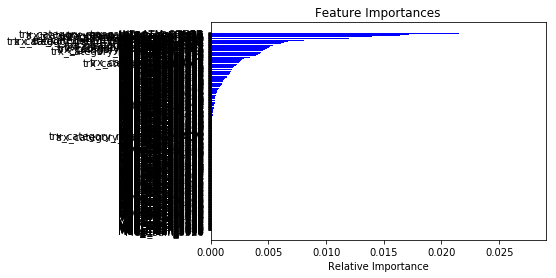

In [96]:
features = X_train.columns
importances = clf.feature_importances_

indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()